<a href="https://colab.research.google.com/github/reban87/LLM_Workshop/blob/main/day1_session2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📅 Day 1 Session 2: Deep Dive into Transformers and Tokenization


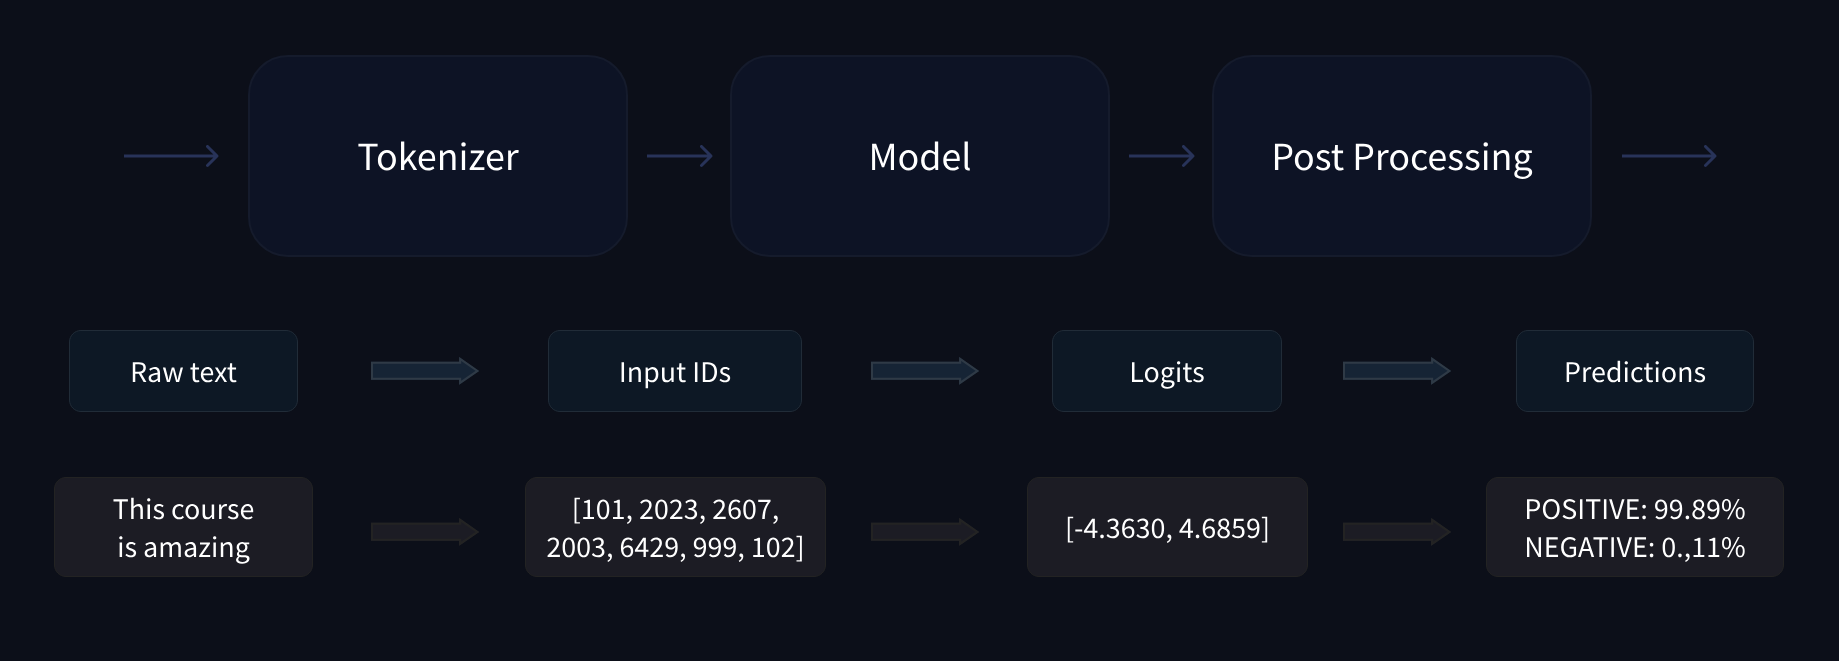

In [1]:
!pip install datasets evaluate transformers[sentencepiece]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00


In [2]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

## Preprocessing with a tokenizer

Like other neural networks, Transformer models can’t process raw text directly, so the first step of our pipeline is to convert the text inputs into numbers that the model can make sense of. To do this we use a tokenizer, which will be responsible for:

- Splitting the input into words, subwords, or symbols (like punctuation) that are called tokens
- Mapping each token to an integer
- Adding additional inputs that may be useful to the model

[Tiktokenizer](https://tiktokenizer.vercel.app/)

In [3]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [4]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [5]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [9]:
import torch

outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


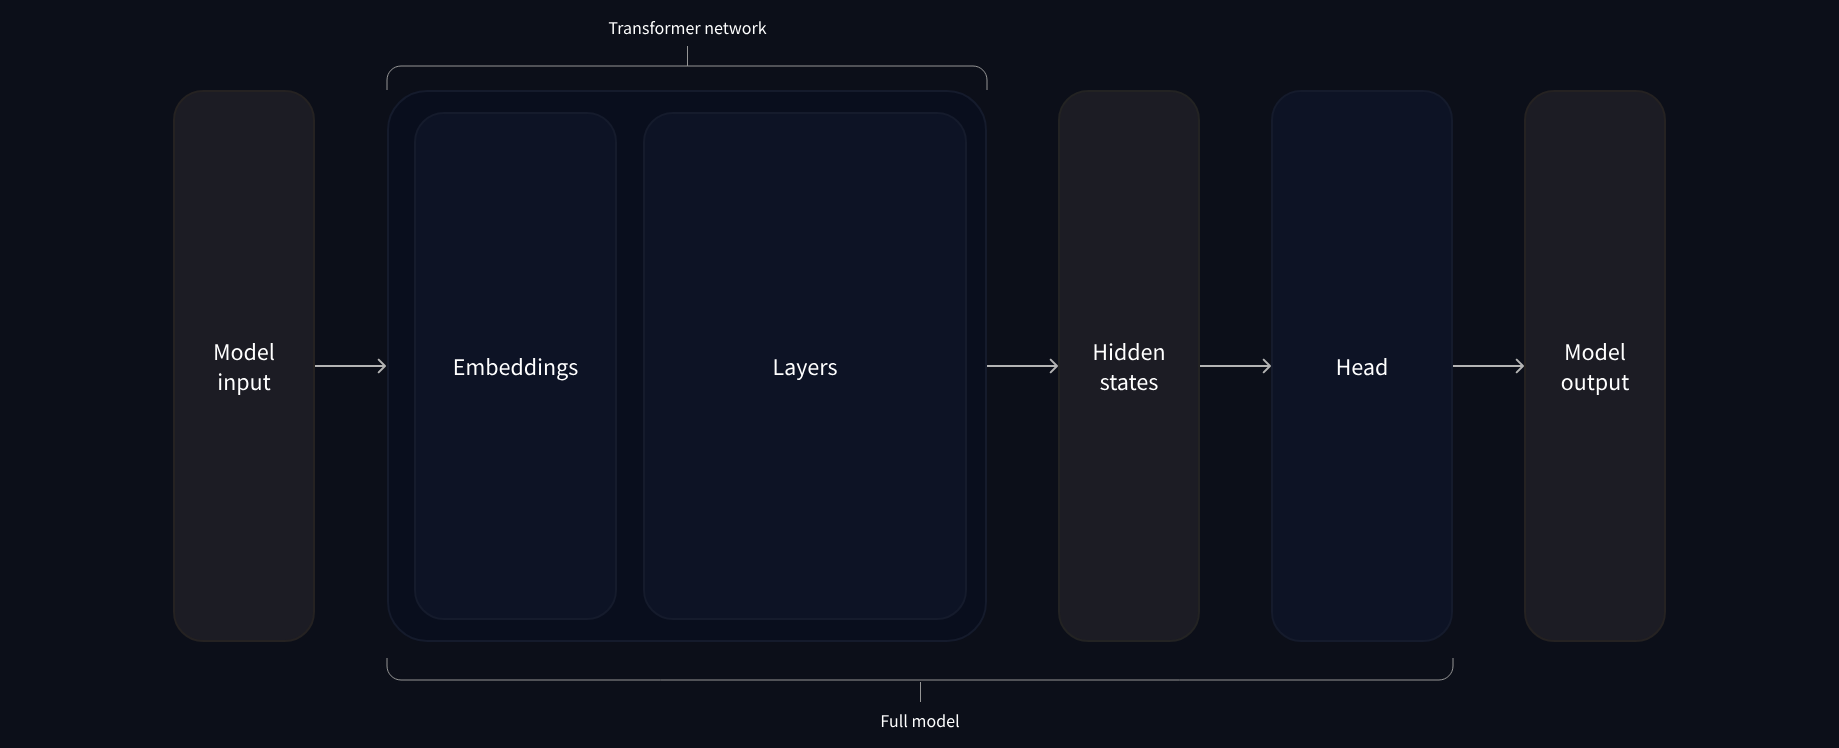

In [10]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

In [12]:
print(outputs.logits.shape)

torch.Size([2, 2])


In [13]:
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


Our model predicted [-1.5607, 1.6123] for the first sentence and [ 4.1692, -3.3464] for the second one. Those are not probabilities but logits, the raw, unnormalized scores outputted by the last layer of the model. To be converted to probabilities, they need to go through a SoftMax layer (all 🤗 Transformers models output the logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, with the actual loss function, such as cross entropy):

In [14]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


In [15]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

Now we can conclude that the model predicted the following:

    First sentence: NEGATIVE: 0.0402, POSITIVE: 0.9598
    Second sentence: NEGATIVE: 0.9995, POSITIVE: 0.0005

Tokenization methods: BPE, WordPiece

In [24]:
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers

# Initialize a BPE tokenizer
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.BpeTrainer(vocab_size=1000, min_frequency=2)
files = ["workshop.txt"]  # use any text file
tokenizer.train(files, trainer)

encoded = tokenizer.encode("Tokenization is useful for NLP models.")
print("BPE Tokens:", encoded.tokens)


BPE Tokens: ['Token', 'ization', 'i', 's', 'u', 's', 'e', 'f', 'u', 'l', 'f', 'or', 'N', 'L', 'P', 'model', 's', '.']


🔸 WordPiece (used in BERT)

In [27]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.WordPieceTrainer(vocab_size=1000, special_tokens=["[UNK]"])
files = ["workshop.txt"]  # use any text file
tokenizer.train(files, trainer)


encoded = tokenizer.encode("Tokenization is useful for NLP models.")
print("WordPiece Tokens:", encoded.tokens)

WordPiece Tokens: ['Tokenization', 'is', 'use', '##f', '##u', '##l', 'f', '##or', '[UNK]', 'models', '.']


🔧 1. Token Construction

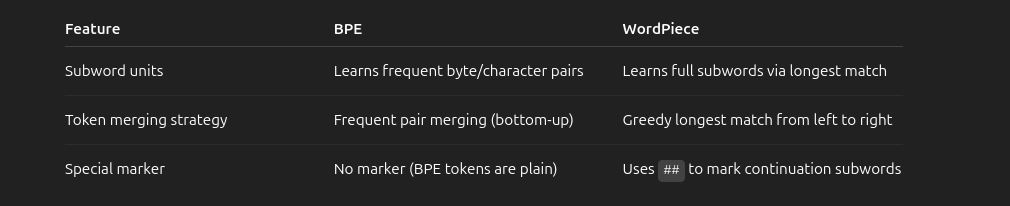

So in WordPiece:

    'use', '##f', '##u', '##l' means:

    use + f + u + l → useful

    but with markers showing it's a continuation of a word.

In BPE:

    It splits "useful" into individual characters ('u', 's', 'e', 'f', 'u', 'l') if no better merge exists.

🚫 2. Unknown Words Handling
Feature	BPE	WordPiece
OOV handling	Breaks down to sub-chars	[UNK] if unknown completely

In your WordPiece output:

    '[UNK]' means: word/token not in vocabulary

    BPE avoids this by continuing to split into smaller pieces all the way down to characters, so never produces [UNK].

This makes BPE more robust for unknown or rare words, but also sometimes more fragmented.
⏱️ 3. Efficiency
Feature	BPE	WordPiece
Speed	Slightly faster	Slightly slower (greedy search)
Token stability	More fragmented sometimes	More stable in language tasks
📚 Summary Table
Feature	BPE	WordPiece
Used in	GPT, RoBERTa, SentencePiece	BERT, DistilBERT
Token merges	Frequent byte/char pair	Greedy longest match
Continuation marker	None	Uses ##
OOV Handling	Breaks down to characters	Emits [UNK] token
Vocabulary training	Bottom-up merges	Top-down match from dictionary
Strength	Robust with rare words	More consistent token boundaries

In [28]:
from transformers import AutoModel, AutoTokenizer
import torch
import time

model_name = "bert-base-uncased"  # change to "gpt2" or "facebook/opt-1.3b" for size comparisons
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

inputs = tokenizer("This is a performance test sentence.", return_tensors="pt")

start = time.time()
with torch.no_grad():
    outputs = model(**inputs)
end = time.time()

print(f"Inference Time: {end - start:.4f} sec")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Inference Time: 0.1367 sec
Model Parameters: 109.48M
